# Synchronous Requests & Basic Plotting
*Written by Sage Lichtenwalner, Rutgers University, June 6, 2018*

*Revised by Lori Garzio (to work with Pangeo), Rutgers University, July 9, 2018*

In this example, we will show how to use the OOI API to make synchronous requests to grab JSON data from the system, and then how to turn that data into some usable plots.

Synchronous requests provide nearly instantaneous results as a JSON object, however, larger requests are also decimated up to a maximum of 20,000 data points.  Asynchronous requests generally take a bit longer (sometimes even more than an hour), but the resulting NetCDF or CSV files include all of the available data.

Before we get started, you will need to look into the OOI Data Portal [https://ooinet.oceanobservatories.org](https://ooinet.oceanobservatories.org) and obtain your **API username and API token**, which you can find in your profile.

## Simple Timeseries Plots

In [1]:
# First, let's import the Python libraries we will need
import requests
import datetime
import matplotlib.pyplot as plt

Next, let's specify some variables we will use to request the data via the API

In [3]:
# API Information
USERNAME =''
TOKEN= ''
API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

For this example, let's grab a year of meteorological data from the [Pioneer Offshore Surface Mooring](http://ooi.visualocean.net/instruments/view/CP04OSSM-SBD11-06-METBKA000) (CP04OSSM).

In [4]:
# Instrument Information
site = 'CP04OSSM'
node = 'SBD11'
instrument = '06-METBKA000'
method = 'telemetered'
stream = 'metbk_a_dcl_instrument'

data_request_url ='/'.join((API_BASE_URL,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-01-01T00:00:00.000Z',
  'endDT':'2018-01-01T00:00:00.000Z',
  'limit':1000,   
}

* beginDT and endDT are used to specify the date range needed.
* "limit" is used to specify the approximate size of the decimated dataset that is returned.  Max is 20,000.
* If we want higher resolution data, we will need to use an asynchronous request

Now, let's grab the data, which is returned as a JSON array so we can convert it into a python object using the requests.json() method.

#### Note: Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

In [5]:
# Grab the data
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()

How may data points were returned?

In [6]:
print( len(data) )

776


Let's take a look at the first element.

In [7]:
data[0]

{'met_heatflx_minute': nan,
 'sea_surface_temperature_qc_results': 29,
 'met_current_direction_qc_results': 29,
 'met_relwind_direction': 22.687094232882828,
 'northward_wind_velocity_qc_executed': 29,
 'met_windavg_mag_corr_east': 4.6688203704788425,
 'shortwave_irradiance_qc_results': 29,
 'dcl_controller_timestamp': 'empty',
 'met_relwind_direction_qc_results': 29,
 'met_relwind_direction_qc_executed': 29,
 'met_current_speed_qc_executed': 29,
 'met_netsirr_qc_executed': 29,
 'met_current_direction_qc_executed': 29,
 'air_temperature': 9.192999839782715,
 'barometric_pressure': 1017.77001953125,
 'precipitation_qc_results': 29,
 'driver_timestamp': 3717918919.7339354,
 'met_current_speed_qc_results': 29,
 'met_spechum': 5.0257182121276855,
 'northward_wind_velocity': 9.699999809265137,
 'air_temperature_qc_results': 29,
 'met_salsurf_qc_executed': 29,
 'eastward_wind_velocity': 7.269999980926514,
 'sea_surface_conductivity': 3.693700075149536,
 'met_barpres_qc_executed': 29,
 'longw

Because we didn't didn't specify any parameters, all parameters for this data stream are included, as well as 2 QC variables for each. As we can see, we have quite few variables here, but we can't easily do anything with this, so let's process the result into something we can use.

Because times are returned as **seconds since 1/1/1900**, we will need a routine to convert them to a native Python datetime format.  
The datetime.utcfromtimestamp() function expects seconds since 1/1/1970, so we also need to adjust for that.

In [8]:
# Time Processing Routine
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

Next we will iterate over the entire data array and save just the parameters we want into new variables.

In [9]:
# Process the data
time = []
air_temp = []
water_temp = []
for i in range(len(data)):
  time.append(ntp_seconds_to_datetime(data[i]['time']))
  air_temp.append(data[i]['air_temperature'])
  water_temp.append(data[i]['sea_surface_temperature'])


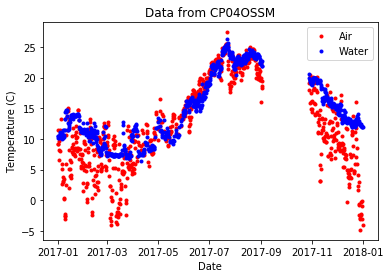

In [10]:
# Let's make a timeseries plot
plt.plot_date(time, air_temp, 'r.', label='Air')
plt.plot_date(time, water_temp, 'b.', label='Water')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.title('Data from %s' % (site));
plt.legend(frameon=1, facecolor='w');

## Profiles & Subplots

Okay, so we can plot a timeseries of temperature easy enough. Let's try to do some more advanced oceanography by looking at some CTD profiles from the [Pioneer Offshore Profiling Mooring](http://ooi.visualocean.net/sites/view/CP04OSPM).

In [11]:
# Instrument Information
site = 'CP04OSPM' #Upstream: CP02PMUO
node = 'WFP01'
instrument = '03-CTDPFK000'
method = 'telemetered'
stream = 'ctdpf_ckl_wfp_instrument'

data_request_url ='/'.join((API_BASE_URL,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-10-24T00:00:00.000Z',
  'endDT':'2017-10-25T00:00:00.000Z',
  'limit':1000,   
}

To keep things simple, we'll only request one day of data this time.

#### Note: Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

In [12]:
# Grab the data
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()

Again, let's take a look at the first item.  The structure is the same, but the variables are different.

In [13]:
data[0]

{'practical_salinity': 35.06789209232038,
 'ctdpf_ckl_seawater_conductivity_qc_results': 29,
 'ctdpf_ckl_seawater_pressure_qc_executed': 29,
 'ctdpf_ckl_seawater_temperature_qc_results': 29,
 'density_qc_executed': 29,
 'driver_timestamp': 3717891868.837419,
 'conductivity': 355303,
 'practical_salinity_qc_results': 29,
 'temperature': 114519,
 'density': 1029.462497287565,
 'ctdpf_ckl_seawater_pressure': 417.65,
 'internal_timestamp': 3717783178.995429,
 'pk': {'node': 'WFP01',
  'stream': 'ctdpf_ckl_wfp_instrument',
  'subsite': 'CP04OSPM',
  'deployment': 7,
  'time': 3717783178.995429,
  'sensor': '03-CTDPFK000',
  'method': 'telemetered'},
 'ctdpf_ckl_seawater_conductivity_qc_executed': 29,
 'ctdpf_ckl_seawater_temperature': 6.4519,
 'ingestion_timestamp': 3717891869.525,
 'port_timestamp': 0.0,
 'time': 3717783178.995429,
 'pressure': 42765,
 'ctdpf_ckl_seawater_pressure_qc_results': 29,
 'preferred_timestamp': 'internal_timestamp',
 'practical_salinity_qc_executed': 29,
 'ctdpf_

This time, rather than the crude "for" loop we used before to convert the dataset into something usable, let's directly import the data into a pandas array.

In [14]:
import pandas as pd
import json

In [15]:
# Convert data to pandas array
profiler = pd.read_json(json.dumps(data))

# Let's keep just the columns we want
profiler = profiler[['time','ctdpf_ckl_seawater_pressure','ctdpf_ckl_seawater_temperature','density','practical_salinity']]

# Display the first few rows
profiler.head(5)

,time,ctdpf_ckl_seawater_pressure,ctdpf_ckl_seawater_temperature,density,practical_salinity
0,3.717783e+09,417.65,6.4519,1029.462497,35.067892
1,3.717792e+09,413.57,6.5647,1029.432291,35.073635
2,3.717792e+09,413.50,6.5640,1029.432313,35.073941
3,3.717792e+09,400.61,6.8025,1029.338502,35.073177
4,3.717792e+09,376.95,7.2963,1029.178622,35.099900


Again, we need to convert time into something usable.  While we're at it, let's also make the new time variable the index for the pandas array, and we'll rename a few columns.

In [16]:
profiler['datetime'] = profiler['time'].apply(ntp_seconds_to_datetime)
profiler = profiler.set_index('datetime')
profiler.rename(columns={'ctdpf_ckl_seawater_pressure': 'pressure',
                        'ctdpf_ckl_seawater_temperature': 'temperature'}, inplace=True)
profiler.head()

,time,pressure,temperature,density,practical_salinity
datetime,,,,,
2017-10-23 21:32:58,3.717783e+09,417.65,6.4519,1029.462497,35.067892
2017-10-24 00:00:02,3.717792e+09,413.57,6.5647,1029.432291,35.073635
2017-10-24 00:01:25,3.717792e+09,413.50,6.5640,1029.432313,35.073941
2017-10-24 00:02:51,3.717792e+09,400.61,6.8025,1029.338502,35.073177
2017-10-24 00:04:18,3.717792e+09,376.95,7.2963,1029.178622,35.099900


Now let's make some plots.  Single variable plots are really easy when you have your data in pandas.

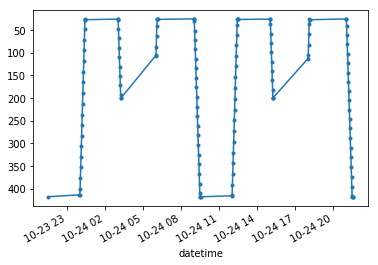

In [17]:
profiler['pressure'].plot(kind='line',marker='.').invert_yaxis();
# Also try, kind='hist' or 'box'

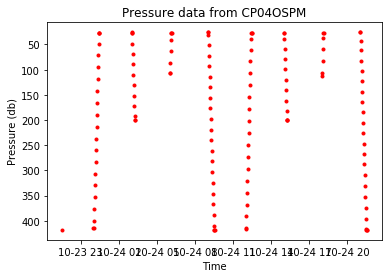

In [18]:
# Or, the old fashined Matplotlib way, let's make a timeseries of pressure
plt.plot_date(profiler.index,profiler.pressure,'r.')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Pressure (db)')
plt.title('Pressure data from %s' % site);

And now, let's make 2 subplots showing profiles of both temperature and salinity.

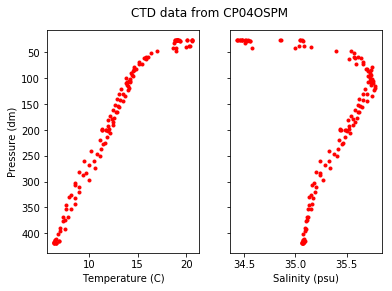

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(profiler.temperature,profiler.pressure,'r.')
ax1.invert_yaxis()
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')

ax2.plot(profiler.practical_salinity,profiler.pressure,'r.')
ax2.set_xlabel('Salinity (psu)')

fig.suptitle('CTD data from %s' % site)
fig.subplots_adjust(top=0.9);

## TS Diagram

You can't call yourself a Physical Oceanographer without making a TS diagram. 

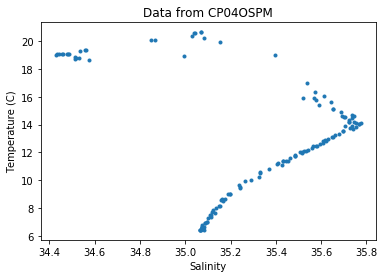

In [20]:
plt.plot(profiler.practical_salinity, profiler.temperature, '.')
plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data from %s' % site);

That's nice, but we can do better.  First, let's color the dots by pressure.  We'll use the "deep" colormap from the [cmocean](https://matplotlib.org/cmocean/#deep) library.

In [21]:
import cmocean

/opt/conda/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


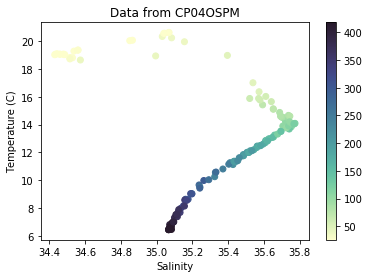

In [22]:
sc = plt.scatter(profiler.practical_salinity, profiler.temperature, 
            c = profiler.pressure, cmap=cmocean.cm.deep)
plt.colorbar(sc)    
plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data from %s' % site);

And now, let's add the density contours, as demonstrated by the example shown on [Ocean Python T-S Diagram](https://oceanpython.org/2013/02/17/t-s-diagram/), though we will use meshgrid instead.  

To calculate density, we will need the wonderful [seawater](https://pythonhosted.org/seawater/index.html) library.

In [23]:
import seawater
import numpy as np 

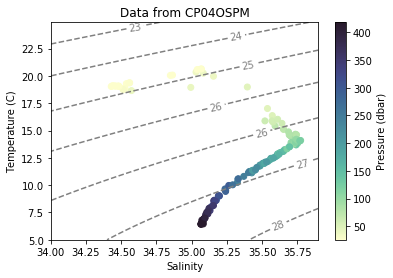

In [24]:
# TS Diagram with density contours
x = np.arange(34, 36, .1)
y = np.arange(5, 25, .1)
X, Y = np.meshgrid(x, y)

Z = seawater.eos80.dens0(X,Y) - 1000 # Substract 1000 to convert to sigma-t

CS = plt.contour(X, Y, Z, colors='grey', linestyles='dashed')
plt.clabel(CS, inline=1, fontsize=10, fmt='%1.0f')


sc = plt.scatter(profiler.practical_salinity, profiler.temperature, 
            c = profiler.pressure, cmap=cmocean.cm.deep)

cb = plt.colorbar(sc)    
cb.set_label('Pressure (dbar)')

plt.xlabel('Salinity')
plt.ylabel('Temperature (C)')
plt.title('Data from %s' % site);

## Some More Hot Fun

Finally, let's take a look at some data from the [3D Thermistor Array](http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-07-TMPSFA301) (TMPSF) deployed in the ASHES Vent field at Axial Seamount.

We can find the ingredients to build the `data_request_url` from the above link.

![RS03ASHS-MJ03B-07-TMPSFA301](https://github.com/ooi-data-review/ooi_datateam_notebooks/raw/master/images/RS03ASHS-MJ03B-07-TMPSFA301.png)

In [26]:
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '07-TMPSFA301'
method = 'streamed'
stream = 'tmpsf_sample'
beginDT = '2017-09-04T10:01:01.000Z'
endDT = '2017-09-05T10:01:01.000Z'

Send the data request.
#### Note: Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

In [27]:
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,
    'limit':1000,   
}

# Grab the data
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()

Again, let's take a look at the first data point.

In [28]:
data[0]

{'temperature14_qc_executed': 29,
 'temperature06_qc_executed': 29,
 'temperature23': 3.297300100326538,
 'temperature24_qc_executed': 29,
 'temperature22': 2.544100046157837,
 'temperature23_qc_results': 29,
 'temperature22_qc_executed': 29,
 'temperature09_qc_executed': 29,
 'temperature03': 3.6041998863220215,
 'temperature02': 2.591599941253662,
 'temperature01': 5.789999961853027,
 'temperature07_qc_results': 29,
 'temperature07': 3.7725000381469727,
 'temperature06': 2.5734000205993652,
 'temperature05': 5.702000141143799,
 'temperature04': 2.6401000022888184,
 'temperature15_qc_results': 29,
 'temperature05_qc_results': 29,
 'temperature09': 2.904099941253662,
 'temperature08': 5.832799911499023,
 'temperature11_qc_results': 29,
 'temperature08_qc_executed': 29,
 'temperature20_qc_executed': 29,
 'driver_timestamp': 3713508060.548236,
 'temperature06_qc_results': 29,
 'battery_voltage': 12.029500007629395,
 'temperature23_qc_executed': 29,
 'temperature16_qc_results': 29,
 'temp

So, we have a bunch of temperature values from the array we can play with.

Remember, time stamps are returned as seconds since 1900-01-01.

This time, let's use the NetCDF library to quickly convert the datetime values. Specifically...

`nc.num2date(timstamp,'seconds since 1900-01-01')`

In [29]:
import netCDF4 as nc

In [30]:
time = []
temperature01 = []

for i in range(len(data)):
    time.append(nc.num2date(data[i]['time'],'seconds since 1900-01-01').replace(microsecond=0))
    temperature01.append(data[i]['temperature01'])

A quick plot shows what appears to be a tidally influenced temperature signal.

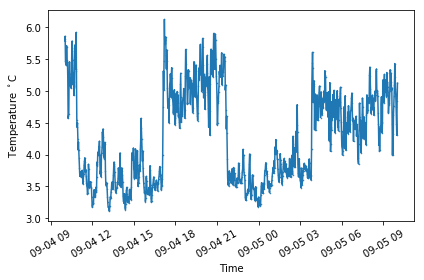

In [31]:
plt.plot(time, temperature01, marker=".", markersize=1, linestyle=None)
plt.ylabel('Temperature $^\circ$C')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Adding in another measurements from another thermistor we can nicely see that the diffuse fluid might be wafting back and for across the 3D array with the tidal current.

In [32]:
temperature03 = []
for i in range(len(data)):
    temperature03.append(data[i]['temperature03'])

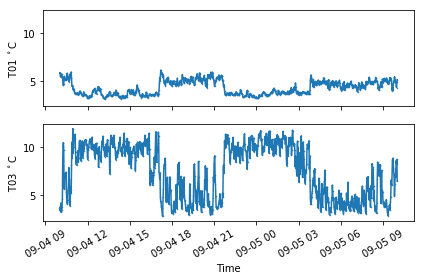

In [33]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.plot(time, temperature01, marker=".", markersize=1, linestyle=None)
ax2.plot(time, temperature03, marker=".", markersize=1, linestyle=None)
ax1.set_ylabel('T01 $^\circ$C')
ax2.set_ylabel('T03 $^\circ$C')
plt.xlabel('Time')
plt.xticks(rotation=30)
plt.tight_layout()
# fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

Finally, we can pull in some pressure data for a closer look at the tidal relationship.
#### Note: Data request lines are commented out to prevent accidental resubmission when running through the entire notebook quickly.

In [34]:
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '09-BOTPTA304'
method = 'streamed'
stream = 'botpt_nano_sample'
beginDT = '2017-09-04T10:01:01.000Z'
endDT = '2017-09-05T10:01:01.000Z'

data_request_url ='/'.join((base_url,subsite,node,sensor,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,
    'limit':1000,   
}

# Grab the data
# r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
# data = r.json()

Extract the pressure variable from the response and convert the time stamps

In [35]:
botpt_time = []
bottom_pressure = []
for i in range(len(data)):
    botpt_time.append(nc.num2date(data[i]['time'],'seconds since 1900-01-01').replace(microsecond=0))
    bottom_pressure.append(data[i]['bottom_pressure'])

Plot co-located temperature 01, 03 and bottom pressure.

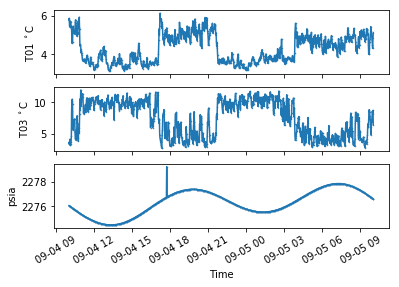

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False)
ax1.plot(time, temperature01, marker=".", markersize=1, linestyle=None)
ax2.plot(time, temperature03, marker=".", markersize=1, linestyle=None)
ax3.plot(botpt_time, bottom_pressure, marker=".", markersize=1, linestyle=None)
ax1.set_ylabel('T01 $^\circ$C')
ax2.set_ylabel('T03 $^\circ$C')
ax3.set_ylabel('psia')
plt.xlabel('Time')
plt.xticks(rotation=30)
# plt.tight_layout()
# fig.subplots_adjust(hspace=0)
# plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.show()

## Bokeh Plots

Because, why not?

In [37]:
# Import Bokeh functions
import os
from bokeh.plotting import figure, output_file, reset_output, show, ColumnDataSource, save
from bokeh.layouts import column
from bokeh.models import BoxAnnotation
from bokeh.io import output_notebook # required to display Bokeh visualization in notebook

In [39]:
source = ColumnDataSource(
    data=dict(
        x=time,
        y1=temperature01,
        y2=temperature03,
        y3=bottom_pressure,
    )
)

# Temperature 01 Plot
s1 = figure(width=500,
           height=300,
           title='Temperature01',
           x_axis_label='Time (GMT)',
           y_axis_label='T01 °C',
           x_axis_type='datetime')

s1.line('x', 'y1', line_width=3, source=source)
s1.circle('x', 'y1', fill_color='white', size=4, source=source)

# Temperature 03 Plot
s2 = figure(width=500,
           height=300,
           title='Temperature03',
           x_axis_label='Time (GMT)',
           y_axis_label='T03 °C',
           x_axis_type='datetime')

s2.line('x', 'y2', line_width=3, source=source)
s2.circle('x', 'y2', fill_color='white', size=4, source=source)

# Pressure Plot
s3 = figure(width=500,
           height=300,
           title='Bottom Pressure',
           x_axis_label='Time (GMT)',
           y_axis_label='psia',
           x_axis_type='datetime')

s3.line('x', 'y3', line_width=3, source=source)
s3.circle('x', 'y3', fill_color='white', size=4, source=source)

output_notebook()
show(column(s1, s2, s3));

# output_file(os.getcwd())
# save(s1, filename='temperature01.html')
# save(s2, filename='temperature03.html')
# save(s3, filename='bottom_pressure.html')

/opt/conda/lib/python3.6/site-packages/bokeh/models/sources.py:138: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 1001), ('y1', 1001), ('y2', 1001), ('y3', 1000)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


Loading BokehJS ...

For more information on Bokeh, check out http://bokeh.pydata.org/en/latest/docs/user_guide/layout.html#rows

Special thanks to Friedrich Knuth and Mike Smith for help developing the above examples.